# This Notebook will demonstrate how you can use classical unsupervised machine learning methods for chunking a document. 

## 0. Import all the libraries.

In [1]:
import cv2
import matplotlib.pyplot as plt
import os
import numpy as np
import hdbscan


## 1. Plot contours, for demonstration. 

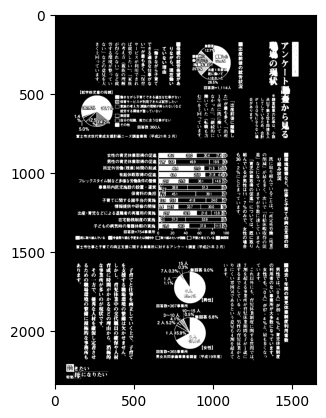

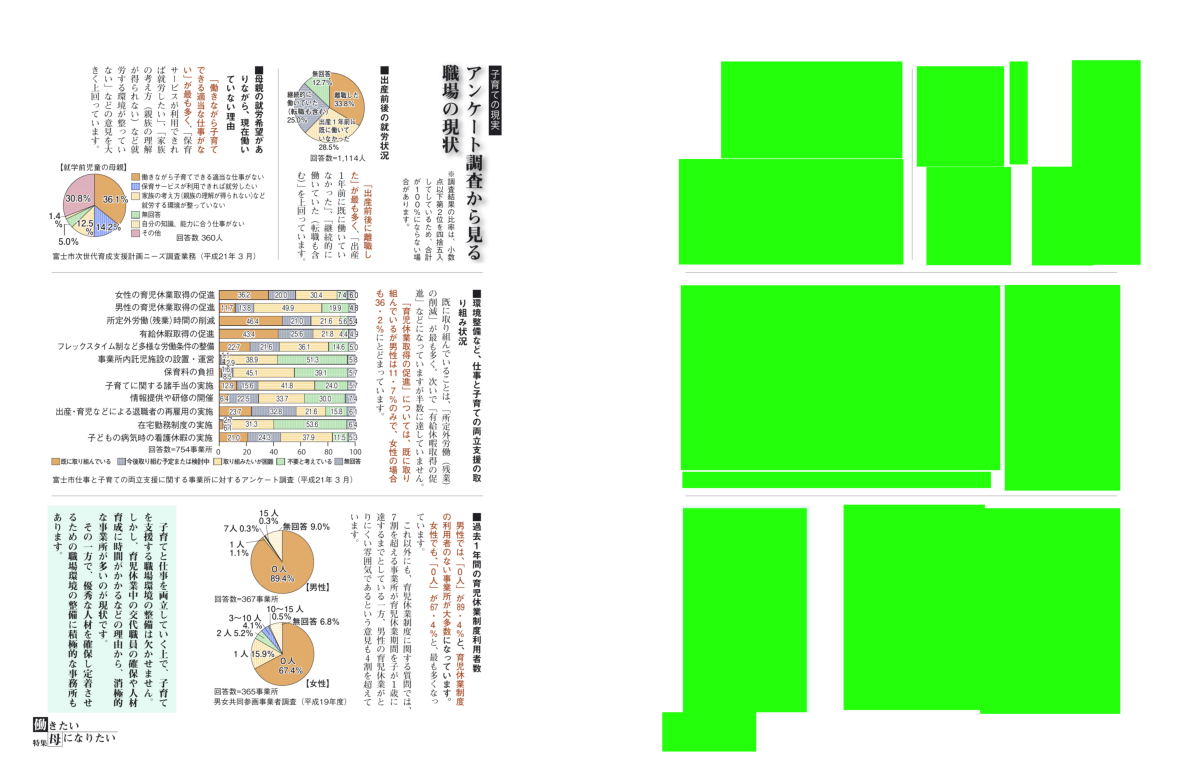

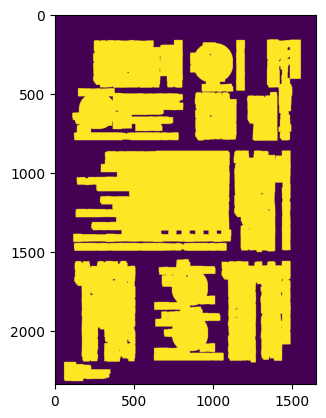

In [3]:

# Load image, grayscale, Gaussian blur, Otsu's threshold, dilate
image = cv2.imread('images/kouhou00807_5.png')
output_dir = 'kouhou00807_5'

original = image.copy()
gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray, (5,5), 0)
thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
plt.imshow(thresh,cmap='gray')
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (15,15))
dilate = cv2.dilate(thresh, kernel, iterations=2)

# Find contours, obtain bounding box coordinates, and extract ROI
cnts = cv2.findContours(dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
image_number = 0
for c in cnts:
    x,y,w,h = cv2.boundingRect(c)
    cv2.rectangle(image, (x, y), (x + w, y + h), (36,255,12), -1)
    ROI = original[y:y+h, x:x+w]
    results_dir = output_dir
    if not os.path.exists(results_dir):
        os.makedirs(results_dir)
    cv2.imwrite(os.path.join(results_dir, "ROI_{}.png".format(image_number)), ROI)
    image_number += 1


plt.figure(figsize=(15, 10))
plt.subplot(1,2,1)
plt.axis('off')
plt.imshow(original)
plt.subplot(1,2,2)
plt.imshow(image)
plt.axis('off')
plt.show()
# plt.imshow(thresh)
plt.imshow(dilate)
 

## 2. Run these cells one by one. at last you will get your chunks

In [5]:

image_path = "images/kouhou00807_5.png"
output_dir = "kouhou00807_5"

image = cv2.imread(image_path)
original = image.copy()
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray, (5,5), 0)
thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (15,15))
dilate = cv2.dilate(thresh, kernel, iterations=2)

cnts = cv2.findContours(dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]

bboxes = []
for c in cnts:
    x, y, w, h = cv2.boundingRect(c)
    bboxes.append((x, y, w, h))

print(f"Found {len(bboxes)} bounding boxes.")


def cluster_bounding_boxes_hdbscan(bboxes, 
                                   min_cluster_size=1, 
                                   min_samples=1):
    """
    Cluster bounding boxes using HDBSCAN.
    Returns an array of labels (same length as bboxes).
    """
    # Convert (x, y, w, h) to feature vectors
    data = []
    for (x, y, w, h) in bboxes:
        centerX = x + w / 2
        centerY = y + h / 2
        data.append([centerX, centerY, w, h])
    
    data = np.array(data)
    
    # Fit HDBSCAN
    clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size,
                                min_samples=min_samples)
    labels = clusterer.fit_predict(data)
    
    return labels



Found 14 bounding boxes.


### This is optional, function.

In [6]:
def limit_clusters(labels, max_clusters=4, bboxes=None):
    """
    Merge smaller clusters until we have at most `max_clusters`.
    `bboxes` can be used if you want to merge by spatial distance.
    """
    labels = np.array(labels)
    # Identify unique clusters (ignore noise label = -1 for merging)
    unique_clusters = [c for c in np.unique(labels) if c != -1]
    n_clusters = len(unique_clusters)
    
    if n_clusters <= max_clusters:
        return labels  # No need to merge
    
    # Optional: Use bounding box centers for cluster centroid calculations
    if bboxes is not None:
        centers = np.array([
            (x + w/2, y + h/2) for (x, y, w, h) in bboxes
        ])
    else:
        # If no bboxes are provided, we can't do spatial merging easily
        # We'll just merge based on cluster size alone.
        centers = None
    
    # Count how many points in each cluster
    cluster_sizes = {}
    for c in unique_clusters:
        cluster_sizes[c] = np.sum(labels == c)
    
    # Sort clusters by size (ascending)
    clusters_sorted_by_size = sorted(unique_clusters, key=lambda c: cluster_sizes[c])
    
    # Merge the smallest clusters first
    while len(clusters_sorted_by_size) > max_clusters:
        smallest_cluster = clusters_sorted_by_size[0]
        
        # Find a cluster to merge into. Let's pick the *closest* bigger cluster by centroid distance.
        # 1. Compute centroid of the smallest cluster
        if centers is not None:
            idx_small = np.where(labels == smallest_cluster)[0]
            centroid_small = centers[idx_small].mean(axis=0)
            
            # 2. Find the nearest centroid among bigger clusters
            min_dist = float('inf')
            merge_target = None
            
            for c in clusters_sorted_by_size[1:]:  # skip the smallest cluster itself
                idx_big = np.where(labels == c)[0]
                centroid_big = centers[idx_big].mean(axis=0)
                dist = np.linalg.norm(centroid_small - centroid_big)
                if dist < min_dist:
                    min_dist = dist
                    merge_target = c
            
            # Merge smallest cluster into merge_target
            labels[idx_small] = merge_target
        else:
            # If we don't have centers, just pick the largest cluster
            largest_cluster = clusters_sorted_by_size[-1]
            labels[labels == smallest_cluster] = largest_cluster
        
        # Recompute cluster list
        unique_clusters = [c for c in np.unique(labels) if c != -1]
        cluster_sizes = {c: np.sum(labels == c) for c in unique_clusters}
        clusters_sorted_by_size = sorted(unique_clusters, key=lambda c: cluster_sizes[c])
    
    return labels


### Testing everything.

In [7]:
# 1. Get bounding boxes from your image
# (Already done above, resulting in `bboxes`)

# 2. Cluster using HDBSCAN
labels = cluster_bounding_boxes_hdbscan(bboxes, 
                                        min_cluster_size=2, 
                                        min_samples=1)

# 3. (Optional) Merge clusters if more than 4
final_labels = limit_clusters(labels, max_clusters=4, bboxes=bboxes)

# Let’s see how many clusters we ended up with
unique_final = [c for c in np.unique(labels) if c != -1]  # otherwise put final_labels
print("Cluster labels (excluding noise):", unique_final)
print("Number of clusters (excluding noise):", len(unique_final))


Cluster labels (excluding noise): [0, 1, 2, 3]
Number of clusters (excluding noise): 4


/home/captainpilot/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/captainpilot/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


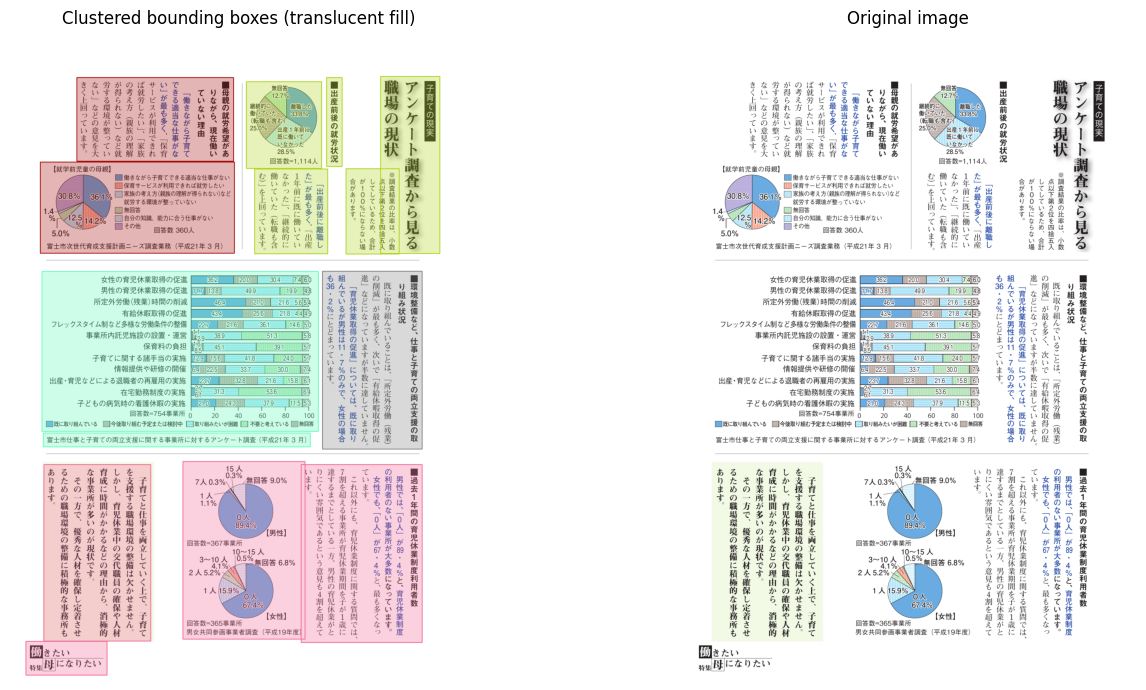

In [8]:
def visualize_clusters_translucent(image, bboxes, labels, alpha=0.3):
    import random
    import numpy as np
    import matplotlib.pyplot as plt
    import cv2
    
    # Generate a color for each cluster
    unique_labels = np.unique(labels)
    color_map = {}
    for c in unique_labels:
        if c == -1:
            # Noise (draw in gray)
            color_map[c] = (128, 128, 128)
        else:
            # Random color
            color_map[c] = tuple([random.randint(0, 255) for _ in range(3)])
    
    # Copy the original image for final visualization
    viz = image.copy()
    # Create an overlay for the filled rectangles
    overlay = viz.copy()
    
    # 1) Draw filled rectangles on the overlay
    for (bbox, label) in zip(bboxes, labels):
        (x, y, w, h) = bbox
        color = color_map[label]
        cv2.rectangle(overlay, (x, y), (x + w, y + h), color, -1)  # -1 fills the rectangle
    
    # 2) Blend the overlay with the base image to achieve translucency
    cv2.addWeighted(overlay, alpha, viz, 1 - alpha, 0, viz)
    
    # 3) (Optional) Draw an outline on top if you still want to see the bounding box edges
    for (bbox, label) in zip(bboxes, labels):
        (x, y, w, h) = bbox
        color = color_map[label]
        cv2.rectangle(viz, (x, y), (x + w, y + h), color, 2)
    
    # Plot the results
    plt.figure(figsize=(15, 7))
    
    # Left subplot: annotated image with translucent bounding boxes
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(viz, cv2.COLOR_BGR2RGB))
    plt.title("Clustered bounding boxes (translucent fill)")
    plt.axis("off")
    
    # Right subplot: original image
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title("Original image")
    plt.axis("off")
    
    plt.tight_layout()
    plt.show()

    
visualize_clusters_translucent(original, bboxes, labels)


In [9]:


def mask_and_crop_clusters(image, bboxes, labels, padding=10):
    """
    For each cluster (including noise label -1), create an image where only the bounding boxes
    of that cluster are preserved and all other areas are white. Then crop the result to the
    overall union (with padding) of that cluster's bounding boxes.
    
    Parameters:
      image: Original image as a numpy array (BGR format).
      bboxes: List of bounding boxes, each as (x, y, w, h).
      labels: Cluster label for each bounding box.
      padding: Additional pixels to pad around the union region.
    
    Returns:
      A dictionary mapping each cluster label to its cropped masked image.
    """
    cluster_results = {}
    unique_labels = np.unique(labels)
    
    for label in unique_labels:
        # Create a white canvas of the same size as the original image.
        masked_image = np.ones_like(image) * 255
        
        # Gather all bounding boxes for the current cluster (including noise if label == -1)
        cluster_boxes = [bbox for bbox, lab in zip(bboxes, labels) if lab == label]
        
        # Copy over the content of the original image for each bounding box in the cluster.
        for (x, y, w, h) in cluster_boxes:
            masked_image[y:y+h, x:x+w] = image[y:y+h, x:x+w]
        
        # Calculate the overall bounding rectangle for the cluster's boxes.
        min_x = min([x for x, y, w, h in cluster_boxes])
        min_y = min([y for x, y, w, h in cluster_boxes])
        max_x = max([x + w for x, y, w, h in cluster_boxes])
        max_y = max([y + h for x, y, w, h in cluster_boxes])
        
        # Apply padding and ensure the coordinates remain within image bounds.
        min_x = max(min_x - padding, 0)
        min_y = max(min_y - padding, 0)
        max_x = min(max_x + padding, image.shape[1])
        max_y = min(max_y + padding, image.shape[0])
        
        # Crop the masked image to the union rectangle.
        crop = masked_image[min_y:max_y, min_x:max_x]
        cluster_results[label] = crop
        
        # Display the crop for this cluster.
        plt.figure(figsize=(6,6))
        plt.imshow(cv2.cvtColor(crop, cv2.COLOR_BGR2RGB))
        plt.title(f"Cluster {label}")
        plt.axis("off")
        plt.show()
    
    return cluster_results

# Example usage:
# Assuming `original` is your image (loaded with cv2.imread),
# `bboxes` is your list of bounding boxes (x, y, w, h),
# and `labels` is an array of cluster labels for each bounding box.
#
# cluster_results = mask_and_crop_clusters(original, bboxes, labels, padding=10)


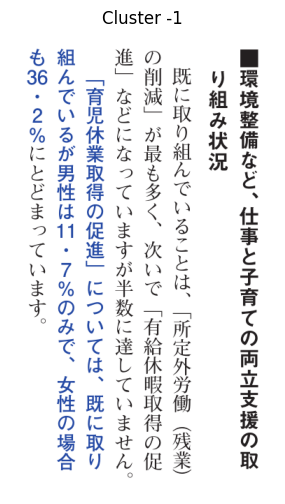

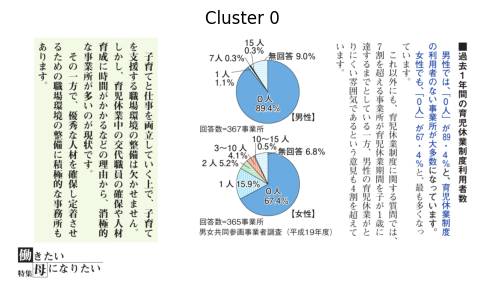

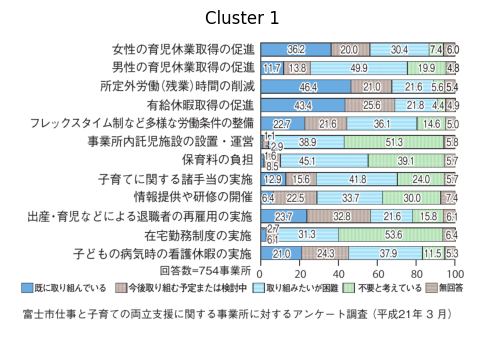

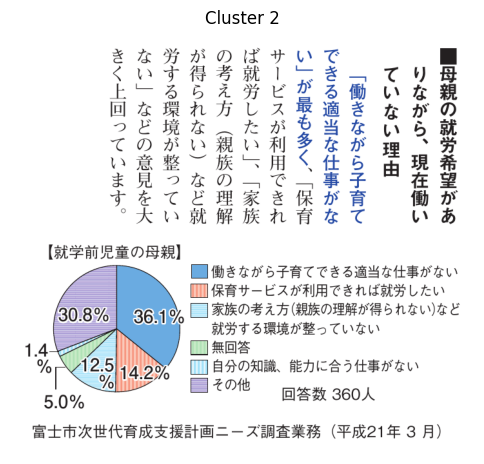

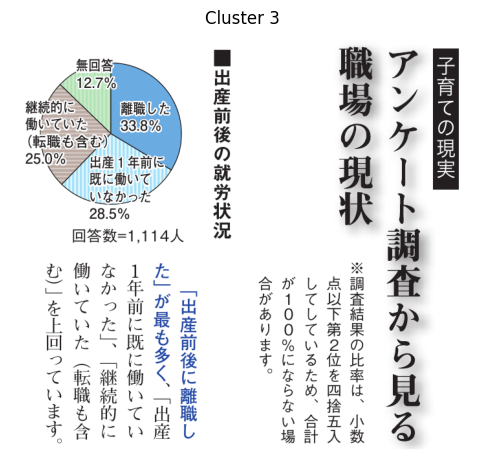

In [10]:
cluster_results = mask_and_crop_clusters(original, bboxes, labels, padding=10)